# Analysis of vulnerabilities in the Rust ecosystem

This notebook analyses the prevelance and types of vulnerabilities found in packages published by `Cargo`.

In [77]:
from typing import Union, List, Literal
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cvss import CVSS2, CVSS3 # converts CVSS strings to score

plt.rcParams['figure.figsize'] = [12, 8] # set figure size

## Data Aggregation

Note: this data was pulled on 11/16/2023.

In [79]:
def convert_severity(severity) -> int:
    """Assumes severity is of form {"type": ..., "score": ... }"""
    if severity["type"] == "CVSS_V3":
        return CVSS3(severity["score"]).scores()[0]
    else:
        return CVSS2(severity["score"]).scores()[0]


def clean_data(data):
    del data["aliases"]
    if len(data["severity"]) > 0:
        data["severity"] = convert_severity(data["severity"][0])
    else:
        data["severity"] = None
    data_affected = data["affected"][0]
    data["affected_name"] = data_affected["package"]["name"]
    data["categories"] = data_affected["database_specific"]["categories"]
    data["affected_info"] = data_affected["database_specific"]["informational"]
    data["events"] = data_affected["ranges"][0]["events"]
    del data["affected"]

    data["reference"] = data["references"][1]["url"]
    del data["references"]
    del data["database_specific"]
    # Convert to datetime type
    data['published'] = pd.to_datetime(data['published'], format='%Y-%m-%dT%H:%M:%SZ')
    data['modified'] = pd.to_datetime(data['modified'], format='%Y-%m-%dT%H:%M:%SZ')

def json_to_osv(file_path: str) -> Union[pd.DataFrame, None]:
    """Given a file path to a json file in the OSV format, returns a populated dataframe."""
    with open(file_path, 'r') as file:
        data = json.load(file)
    if "withdrawn" in data:
        return None
    clean_data(data)
    df = pd.DataFrame.from_dict(data, orient="index").T
    df = df.astype({'severity': 'Float32'})
    df = df.astype({'summary': 'string'})
    df = df.astype({'details': 'string'})
    df = df.astype({'affected_name': 'string'})
    df = df.astype({'affected_info': 'category'})
    df['published'] = pd.to_datetime(df['published'])
    df['modified'] = pd.to_datetime(df['modified'])
    return df
    

In [80]:
# Folder containing RustSec advisories in the OSV format
folder_path = './advisory-db-osv/crates/'

# Read in all vulnerabilities
dataframes = []
for filename in os.listdir(folder_path):
    if filename.endswith('.json'):
        # Construct the full path to the JSON file
        file_path = os.path.join(folder_path, filename)
        # Read the JSON file into a DataFrame
        osv = json_to_osv(file_path)
        if osv is not None:
            dataframes.append(json_to_osv(file_path))
        
# Concatenate all DataFrames into a single DataFrame
df = pd.concat(dataframes, ignore_index=True)

## Data Analysis

### General Stats

In [81]:
num_vul = df.shape[0]
print(f"Number of advisories: {num_vul}")
df.sort_values('id').head()

Number of advisories: 550


,id,modified,published,related,summary,details,severity,affected_name,categories,affected_info,events,reference
12,RUSTSEC-2016-0001,2023-06-13 13:10:24,2016-11-05 12:00:00,[],SSL/TLS MitM vulnerability due to insecure def...,All versions of rust-openssl prior to 0.9.0 co...,8.1,openssl,[],NaN,"[{'introduced': '0.0.0-0'}, {'fixed': '0.9.0'}]",https://rustsec.org/advisories/RUSTSEC-2016-00...
532,RUSTSEC-2016-0002,2023-06-13 13:10:24,2016-05-09 12:00:00,[RUSTSEC-2016-0001],HTTPS MitM vulnerability due to lack of hostna...,"When used on Windows platforms, all versions o...",4.8,hyper,[crypto-failure],NaN,"[{'introduced': '0.0.0-0'}, {'fixed': '0.9.4'}]",https://rustsec.org/advisories/RUSTSEC-2016-00...
430,RUSTSEC-2016-0003,2023-06-13 13:10:24,2016-08-01 12:00:00,[],HTTP download and execution allows MitM RCE,The build script in the portaudio crate will a...,5.9,portaudio,[],NaN,[{'introduced': '0.0.0-0'}],https://rustsec.org/advisories/RUSTSEC-2016-00...
352,RUSTSEC-2016-0004,2020-10-02 01:29:11,2016-09-10 12:00:00,[],libusb is unmaintained; use rusb instead,The `libusb` crate has not seen a release sinc...,<NA>,libusb,[],unmaintained,"[{'introduced': '0.0.0-0'}, {'fixed': '0.3.1-0'}]",https://rustsec.org/advisories/RUSTSEC-2016-00...
328,RUSTSEC-2016-0005,2022-01-09 20:07:15,2016-09-06 12:00:00,[],rust-crypto is unmaintained; switch to a moder...,The `rust-crypto` crate has not seen a release...,<NA>,rust-crypto,[],unmaintained,"[{'introduced': '0.0.0-0'}, {'fixed': '0.2.37-...",https://rustsec.org/advisories/RUSTSEC-2016-00...


### Frequency of RUSTSECs

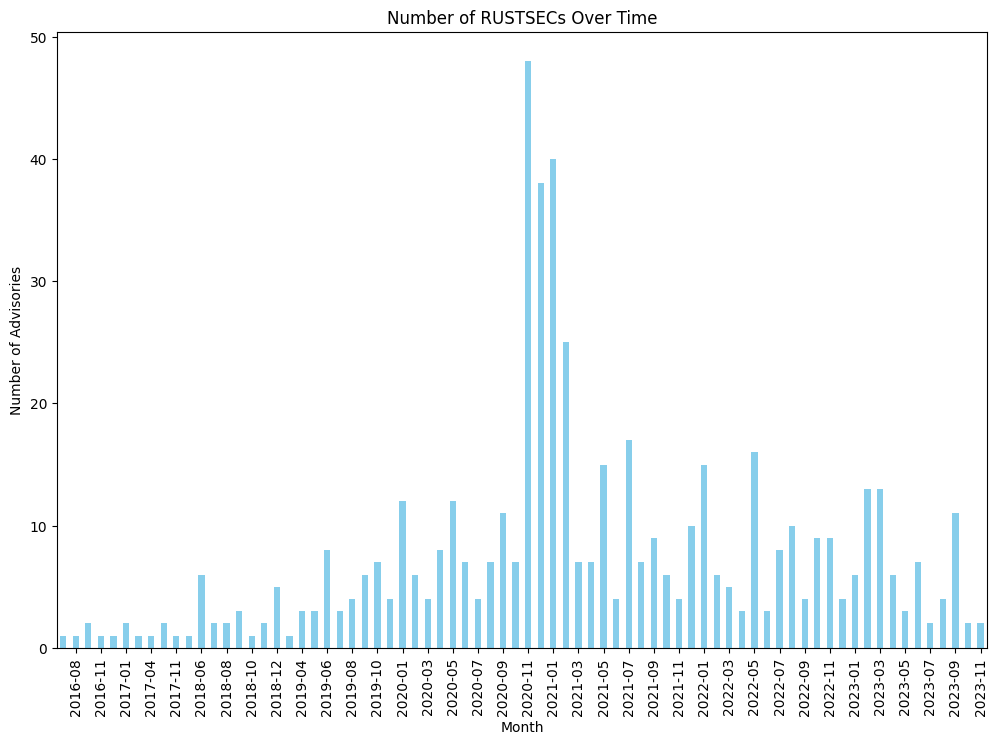

In [84]:
def plot_all_advisories(df, save_path = ''):
    monthly_counts = df['published'].groupby(df['published'].dt.to_period("M")).count()
    # Plotting
    monthly_counts.plot(kind='bar', color='skyblue')
    
    # Adding labels and title
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=2))
    plt.xlabel('Month')
    plt.ylabel('Number of Advisories')
    plt.title('Number of RUSTSECs Over Time')
    if save_path != '':
        plt.savefig(save_path, dpi=300, bbox_inches = "tight")
    plt.show()

plot_all_advisories(df)

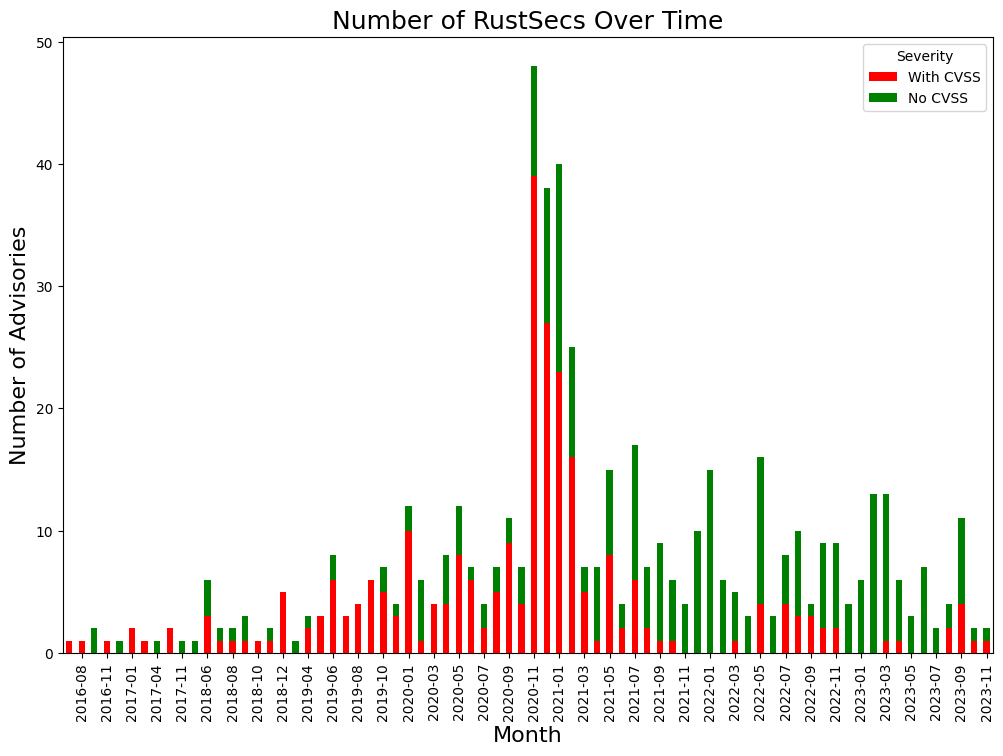

In [101]:
def plot_rustsec_over_time(df, save_path = ''):
    # Group by month and count occurrences of NaN and non-NaN 'severity'
    df['severity_is_nan'] = df['severity'].isna()
    monthly_counts = df.groupby([df['published'].dt.to_period("M"), 'severity_is_nan']).size().unstack(fill_value=0)
    
    # Plotting a stacked bar plot
    ax = monthly_counts.plot(kind='bar', stacked=True, color=['red', 'green'])
    
    # Adding labels and title
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=2))
    plt.xlabel('Month', fontsize= 16)
    plt.ylabel('Number of Advisories', fontsize=16)
    plt.title('Number of RustSecs Over Time', fontsize = 18)
    legend_labels = ["With CVSS", "No CVSS"]
    ax.legend(legend_labels, title='Severity')
    if save_path != '':
        plt.savefig(save_path, dpi=300, bbox_inches = "tight")
    plt.show()

plot_rustsec_over_time(df, 'graphs/advisories-over-time.png')

### CVSS Scores

Number of vulnerabilities without score: 284, that's 51.64%.
Average CVSS score: 7.63346004486084
Standard deviation of CVSS score: 1.635632038116455


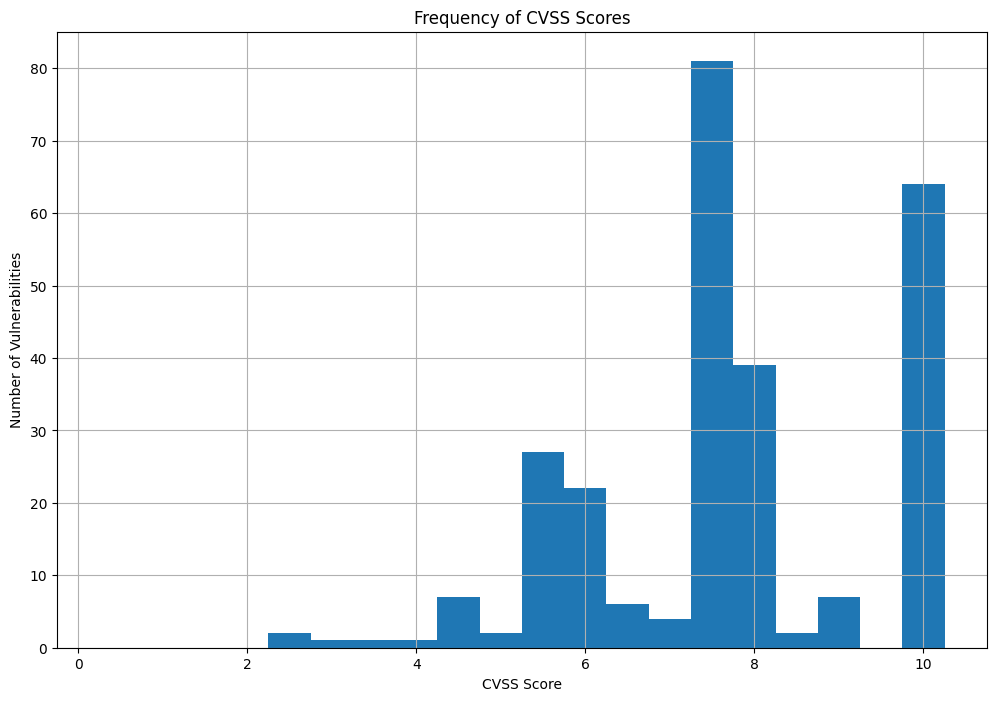

In [86]:
def plot_cvss_scores(df, save_path = ''):
    df['severity'].hist(bins=np.linspace(0.25,10.25,21))
    plt.title("Frequency of CVSS Scores")
    plt.xlabel('CVSS Score')
    plt.ylabel('Number of Vulnerabilities')
    if save_path != '':
        plt.savefig(save_path, dpi=300, bbox_inches = "tight")
    plt.show()
    
num_no_score = df['severity'].isna().sum()
num_score = num_vul - num_no_score
print(f"Number of vulnerabilities without score: {num_no_score}, that's {round(num_no_score / df.shape[0], 4) * 100}%.")
print(f"Average CVSS score: {df['severity'].mean()}")
print(f"Standard deviation of CVSS score: {df['severity'].std()}")
plot_cvss_scores(df, 'graphs/cvss-scores.png')

### Maintenance


In [87]:
num_unmain = df['affected_info'].value_counts()['unmaintained']
print(f"Number of unmaintained packages: {num_unmain}, that's {round(num_unmain / num_vul, 4) * 100}%.")
num_unmain_w_vuln = df[(~df['severity'].isna()) & (df['affected_info'] == "unmaintained")].shape[0]
print(f"Number of packages that are unmaintained and have vulnerability scores: {num_unmain_w_vuln}, that's {round(num_unmain_w_vuln / num_score, 4) * 100}% of packages with a CVSS score.")

Number of unmaintained packages: 100, that's 18.18%.
Number of packages that are unmaintained and have vulnerability scores: 2, that's 0.75% of packages with a CVSS score.


### Vulnerability Types

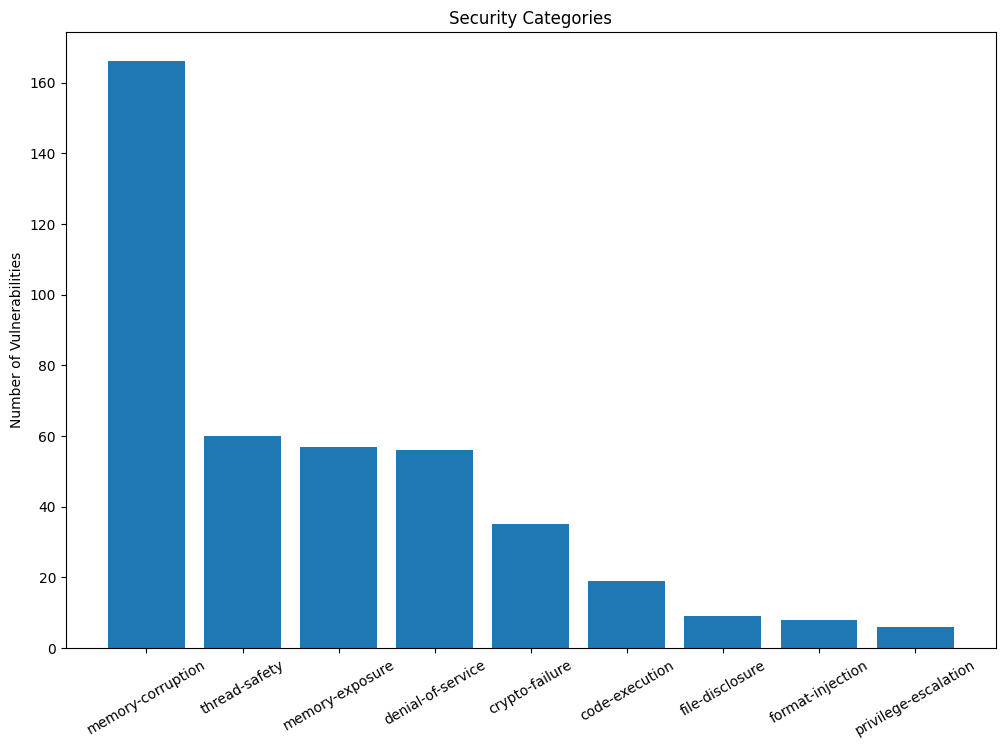

In [104]:
from collections import Counter

def get_type_counts(data):
    counts = Counter()
    for category in data["categories"]:
        counts += Counter(category)
    return counts

def plot_security_categories(df, save_path = ''):
    type_counts = get_type_counts(df)
    type_counts = list(zip(*type_counts.most_common()))
    plt.bar(type_counts[0], type_counts[1])
    plt.xticks(rotation=30)
    plt.ylabel('Number of Vulnerabilities')
    plt.title("Security Categories")
    if save_path != '':
        plt.savefig(save_path, dpi=300, bbox_inches = "tight")
    plt.show()

plot_security_categories(df, 'graphs/security-categories.png')

### Patches


In [89]:
import re

def extract_semver_versions(semver_string):
    pattern = re.compile(r'(\d+)\.(\d+)\.(\d+)')
    match = pattern.match(semver_string)
    
    if match:
        major_version = int(match.group(1))
        minor_version = int(match.group(2))
        patch_version = int(match.group(3))
        return major_version, minor_version, patch_version
    else:
        return -1, -1, -1

def is_fixed(patches: List) -> bool:
    """Returns whether the patches list from the events column contains a fix."""
    for event in patches:
        if 'fixed' in event.keys():
            return True
    return False

In [90]:
count_fixed_with_score = df.loc[~df['severity'].isna(), 'events'].apply(is_fixed).sum()
count_fixed_all = df['events'].apply(is_fixed).sum()
print(f"Number of fixed vulnerabilities: {count_fixed_all}. (Including vulnerabilities without a score.)")
print(f"Number of fixed vulnerabilities with CVSS scores: {count_fixed_with_score}, that's {round(count_fixed_with_score / num_score, 4) * 100}% of vulnerabilties with a CVSS score.")

Number of fixed vulnerabilities: 383. (Including vulnerabilities without a score.)
Number of fixed vulnerabilities with CVSS scores: 218, that's 81.95% of vulnerabilties with a CVSS score.


In [91]:
def patches_until_fix(patches: List):
    if not is_fixed(patches):
        return (-1, -1, -1)
    # We are calculating the time it takes for a patch only for the first two events because:
    # - They are always introduced and fixed in that order.
    # - From what we can tell, if there are more events, they are different versions of the package that contain the same bug. 
    #   They tend to get patched all at the same time. Therefore, since the first introduced is the oldest version, 
    #   we think this is a good proxy.
    intro = extract_semver_versions(patches[0]['introduced'])
    fix = extract_semver_versions(patches[1]['fixed'])
    if intro[0] < fix[0]:
        return (fix[0] - intro[0], fix[1], fix[2])
    if intro[1] < fix[1]:
        return (0, fix[1] - intro[1], fix[2])
    if intro[2] < fix[2]:
        return (0, 0, fix[2] - intro[2])
    return (0, 0, 0)

def get_patch_type(versions) -> Literal['major', 'minor', 'patch', 'not-fixed']:
    """Given a versions tuple, returns 'major', 'minor', or 'patch', 'not-fixed'."""
    if versions[0] > 0:
        return 'major'
    if versions[0] == 0 and versions[1] > 0:
        return 'minor'
    if versions[0] == 0 and versions[1] == 0 and versions[2] > 0:
        return 'patch'
    return 'not-fixed'

def count_num_patches(versions, kind: Literal['major', 'minor', 'patch']):
    """Given a tuple of versions until patch, returns how many major, minor, or patch updates there are."""
    if kind == 'major' and versions[0] > 0:
        return versions[0]
    if kind == 'minor' and versions[0] == 0 and versions[1] > 0:
        return versions[1]
    if kind == 'patch' and versions[0] == 0 and versions[1] == 0 and versions[2] > 0:
        return versions[2]
    return 0

In [92]:
df['patches_til_fix'] = df['events'].apply(patches_until_fix)
num_major_fixes = df['patches_til_fix'].apply(count_num_patches, kind='major').apply(lambda x: 1 if x > 0 else 0).sum()
num_minor_fixes = df['patches_til_fix'].apply(count_num_patches, kind='minor').apply(lambda x: 1 if x > 0 else 0).sum()
num_patch_fixes = df['patches_til_fix'].apply(count_num_patches, kind='patch').apply(lambda x: 1 if x > 0 else 0).sum()
print("How long did it take to get fixed? (Counting vulnerabilties with and without CVSS score.)")
print(f"\t- {num_major_fixes} times it required a major version update.")
print(f"\t- {num_minor_fixes} times it required a minor version update.")
print(f"\t- {num_patch_fixes} times it required only a patch.")

How long did it take to get fixed? (Counting vulnerabilties with and without CVSS score.)
	- 76 times it required a major version update.
	- 256 times it required a minor version update.
	- 51 times it required only a patch.


In [93]:
avg_major_versions = df['patches_til_fix'].apply(count_num_patches, kind='major').mean()
avg_minor_versions = df['patches_til_fix'].apply(count_num_patches, kind='minor').mean()
avg_patch_versions = df['patches_til_fix'].apply(count_num_patches, kind='patch').mean()
print("For each patch type, how many versions does it take on average?")
print(f"\t- Major: {round(avg_major_versions, 2)} updates on average.")
print(f"\t- Minor: {round(avg_minor_versions, 2)} updates on average.")
print(f"\t- Patch: {round(avg_patch_versions, 2)} updates on average.")

For each patch type, how many versions does it take on average?
	- Major: 2.48 updates on average.
	- Minor: 3.84 updates on average.
	- Patch: 0.51 updates on average.


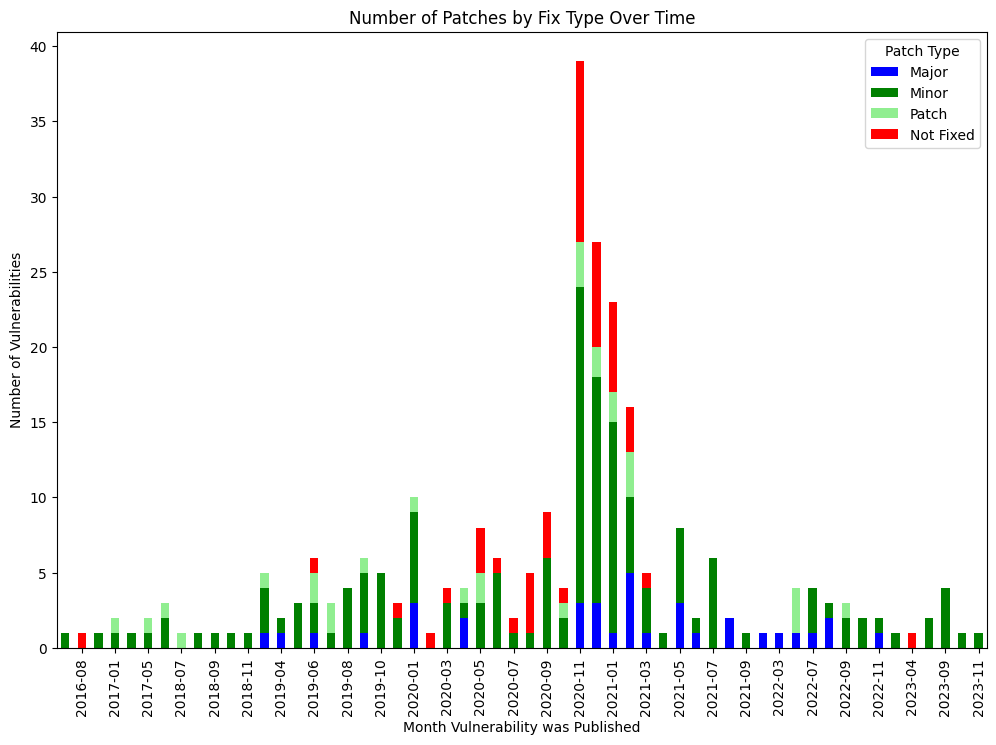

In [94]:
def plot_patches_over_time(df, save_path = ''):
    # Only consider CVSS vulnerabilities
    df_filtered = df.dropna(subset=['severity']).copy()
    df_filtered['p-major'] = df['patches_til_fix'].apply(get_patch_type).apply(lambda x: 1 if x == 'major' else 0)
    df_filtered['p-minor'] = df['patches_til_fix'].apply(get_patch_type).apply(lambda x: 1 if x == 'minor' else 0)
    df_filtered['p-patch'] = df['patches_til_fix'].apply(get_patch_type).apply(lambda x: 1 if x == 'patch' else 0)
    df_filtered['p-not-fixed'] = df['patches_til_fix'].apply(get_patch_type).apply(lambda x: 1 if x == 'not-fixed' else 0)

    # Group by month and sum the occurrences of each patch type
    monthly_counts = df_filtered.groupby([df_filtered['published'].dt.to_period("M")])[['p-major', 'p-minor', 'p-patch', 'p-not-fixed']].sum()
    
    # Plotting a stacked bar plot
    ax = monthly_counts.plot(kind='bar', stacked=True, color=['blue', 'green', 'lightgreen', 'red'])
    
    # Adding labels and title
    plt.xlabel('Month Vulnerability was Published')
    plt.ylabel('Number of Vulnerabilities')
    plt.title('Number of Patches by Fix Type Over Time')
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=2))
    
    # Customize legend labels
    legend_labels = ['Major', 'Minor', 'Patch', 'Not Fixed']
    ax.legend(legend_labels, title='Patch Type')
    if save_path != '':
        plt.savefig(save_path, dpi=300, bbox_inches = "tight")
    # Display the plot
    plt.show()

plot_patches_over_time(df, 'graphs/fix_types.png')